# DSA2101 Group Project: Global Variation in Passport Power
---

Load necessary packages and download data required:

In [1]:
%%capture

# Load libraries
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import pandas as pd
import numpy as np
import calendar
import matplotlib.pyplot as plt
import seaborn as sns
import pydytuesday

# Download dataset (this prints a lot of messages unless captured)
pydytuesday.get_date('2025-09-09')

# Read datasets
country_lists = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2025/2025-09-09/country_lists.csv')
rank_by_year = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2025/2025-09-09/rank_by_year.csv')


In [2]:
rank_by_year.head()

,code,country,region,rank,visa_free_count,year
0,AF,Afghanistan,ASIA,116,26,2021
1,AF,Afghanistan,ASIA,106,26,2020
2,AF,Afghanistan,ASIA,106,30,2018
3,AF,Afghanistan,ASIA,104,24,2017
4,AF,Afghanistan,ASIA,104,25,2016


In [3]:
country_lists.head()

,code,country,visa_required,visa_online,visa_on_arrival,visa_free_access,electronic_travel_authorisation
0,PS,Palestinian Territory,"[[{""code"":""AF"",""name"":""Afghanistan""},{""code"":""...","[[{""code"":""AG"",""name"":""Antigua and Barbuda""},{...","[[{""code"":""BD"",""name"":""Bangladesh""},{""code"":""B...","[[{""code"":""BO"",""name"":""Bolivia""},{""code"":""CK"",...","[[{""code"":""LK"",""name"":""Sri Lanka""},{""code"":""KE..."
1,AD,Andorra,"[[{""code"":""AF"",""name"":""Afghanistan""},{""code"":""...","[[{""code"":""AO"",""name"":""Angola""},{""code"":""AZ"",""...","[[{""code"":""BH"",""name"":""Bahrain""},{""code"":""BD"",...","[[{""code"":""JP"",""name"":""Japan""},{""code"":""AL"",""n...","[[{""code"":""AU"",""name"":""Australia""},{""code"":""CA..."
2,VA,Vatican City,"[[{""code"":""AF"",""name"":""Afghanistan""},{""code"":""...","[[{""code"":""AZ"",""name"":""Azerbaijan""},{""code"":""B...","[[{""code"":""BH"",""name"":""Bahrain""},{""code"":""BD"",...","[[{""code"":""AL"",""name"":""Albania""},{""code"":""AD"",...","[[{""code"":""AU"",""name"":""Australia""},{""code"":""CA..."
3,SM,San Marino,"[[{""code"":""AF"",""name"":""Afghanistan""},{""code"":""...","[[{""code"":""AZ"",""name"":""Azerbaijan""},{""code"":""B...","[[{""code"":""BH"",""name"":""Bahrain""},{""code"":""BD"",...","[[{""code"":""JP"",""name"":""Japan""},{""code"":""AL"",""n...","[[{""code"":""AU"",""name"":""Australia""},{""code"":""CA..."
4,MC,Monaco,"[[{""code"":""AF"",""name"":""Afghanistan""},{""code"":""...","[[{""code"":""AZ"",""name"":""Azerbaijan""},{""code"":""B...","[[{""code"":""BH"",""name"":""Bahrain""},{""code"":""BD"",...","[[{""code"":""JP"",""name"":""Japan""},{""code"":""AL"",""n...","[[{""code"":""AU"",""name"":""Australia""},{""code"":""CA..."


### 1. Introduction
---

For this project, we shall focus on the **“Henley Passport Index”** dataset from the TidyTuesday repository, published on 9 September 2025. Taken from Henley & Partners and compiled by TidyTuesday contributors, this dataset records passport mobility across the world. It provides information on the number of destinations that passport holders can enter without a prior visa, alongside various types of non-free entry requirements such as e-Visas, visas-on-arrival and Electronic Travel Authorisations (eTAs). These details allow us to examine global disparities in international mobility.

The “Henley Passport Index” dataset contains the following files:

- **country_lists.csv**: For each passport–destination pair, this file records the type of entry requirement (visa-free, visa-required, e-Visa, visa-on-arrival, or eTA), together with standardised country and destination codes.

- **rank_by_year.csv**: For each country, this file contains historical data (2014–2025) on visa-free access counts, annual rankings, and region identifiers.

- **Note:** Visa-free access refers to destinations that can be entered without prior authorisation. Although eTAs and e-Visas both require online applications, eTAs are generally processed quickly with high approval certainty, while e-Visas are closer in complexity to traditional visas.

We use this dataset to examine global variation in passport power. Specifically, we analyse:

1. how passport strength differs geographically,  
2. how it has changed over the past decade, and  
3. how different passport groups experience non-free access requirements.

**Our central question is:**

> **How and why does passport power vary across world regions, and how has it changed over time?**

To answer this, we construct three visualisations—a global map, a multi-panel time series, and a stacked bar chart—to capture different dimensions of international mobility. These plots jointly allow us to explore both the level and the structure of travel freedom across the world.


### 2. Data Cleaning and Summary
---


In [4]:
## Cleaning of country_list csv

## Cleaning of the country list csv to expand it to few dataframes

For this CSV, we first load all JSON files from columns of the original dataframe, flatten the nested objects into new lists, and turn them into new dataframes. After that, we combine the sub-dataframes into a long format. In the final dataframe, df_country_list, there are three columns: country_name is the name of the host country, visa_type is the type of visa required by the destination country, and destination_country shows the name of the destination country. In the visa_type column, there are five main types: visa-free, visa-on-arrival, visa-online, electronic-travel-authorisation(ETA), and visa-required.

With this cleaned dataframe, we would be able to know each type of visa required by the destination country for the respective home countries. Among these visa types, visa-free and visa-on-arrival would be counted as score 1 for further ranking, and others would be assigned a score of 0. 

In [5]:
import json
from pandas import json_normalize

### Expand visa_free_access	column
all_visa_free = []

for i in range(len(country_lists)):
    text = country_lists.loc[i, "visa_free_access"]
    if pd.notna(text):  
        try:
            data = json.loads(text)
            if isinstance(data, list) and len(data) > 0 and isinstance(data[0], list):
                data = data[0]  
            temp = json_normalize(data)
            temp["code_country"] = country_lists.loc[i, "code"]
            temp["country_name"] = country_lists.loc[i, "country"]
            all_visa_free.append(temp)
        except:
            pass
visa_free_clean = pd.concat(all_visa_free, ignore_index=True)
visa_free_clean.to_csv("visa_free_access_clean.csv", index=False)
visa_free = pd.read_csv("visa_free_access_clean.csv")
visa_free = visa_free.rename(columns={"name": "visa_free_country"})
visa_free.head()

### Expand visa_required column
all_visa_required = []

for i in range(len(country_lists)):
    text = country_lists.loc[i, "visa_required"]
    if pd.notna(text):  
        try:
            data = json.loads(text)
            if isinstance(data, list) and len(data) > 0 and isinstance(data[0], list):
                data = data[0]  
            temp = json_normalize(data)
            temp["code_country"] = country_lists.loc[i, "code"]
            temp["country_name"] = country_lists.loc[i, "country"]
            all_visa_required.append(temp)
        except:
            pass
visa_required_clean = pd.concat(all_visa_required, ignore_index=True)
visa_required_clean.to_csv("visa_required_clean.csv", index=False)
visa_required = pd.read_csv("visa_required_clean.csv")
visa_required = visa_required.rename(columns={"name": "visa_required_country"})
visa_required.head()

### Expand visa_online column
all_visa_online = []

for i in range(len(country_lists)):
    text = country_lists.loc[i, "visa_online"]
    if pd.notna(text):  
        try:
            data = json.loads(text)
            if isinstance(data, list) and len(data) > 0 and isinstance(data[0], list):
                data = data[0]  
            temp = json_normalize(data)
            temp["code_country"] = country_lists.loc[i, "code"]
            temp["country_name"] = country_lists.loc[i, "country"]
            all_visa_online.append(temp)
        except:
            pass

visa_online_clean = pd.concat(all_visa_online, ignore_index=True)
visa_online_clean.to_csv("visa_online_clean.csv", index=False)
visa_online = pd.read_csv("visa_online_clean.csv")
visa_online = visa_online.rename(columns={"name": "visa_online_country"})
visa_online.head()

### Expand visa_on_arrival column
all_visa_on_arrival = []

for i in range(len(country_lists)):
    text = country_lists.loc[i, "visa_on_arrival"]
    if pd.notna(text):  
        try:
            data = json.loads(text)
            if isinstance(data, list) and len(data) > 0 and isinstance(data[0], list):
                data = data[0]  
            temp = json_normalize(data)
            temp["code_country"] = country_lists.loc[i, "code"]
            temp["country_name"] = country_lists.loc[i, "country"]
            all_visa_on_arrival.append(temp)
        except:
            pass

visa_on_arrival = pd.concat(all_visa_on_arrival, ignore_index=True)
visa_on_arrival.to_csv("visa_on_arrival.csv", index=False)
visa_on_arrival = pd.read_csv("visa_on_arrival.csv")
visa_on_arrival = visa_on_arrival.rename(columns={"name": "visa_on_arrival_country"})
visa_on_arrival.head()

### Expand electronic_travel_authorisation column
all_electronic_travel_authorisation = []

for i in range(len(country_lists)):
    text = country_lists.loc[i, "electronic_travel_authorisation"]
    if pd.notna(text):  
        try:
            data = json.loads(text)
            if isinstance(data, list) and len(data) > 0 and isinstance(data[0], list):
                data = data[0]  
            temp = json_normalize(data)
            temp["code_country"] = country_lists.loc[i, "code"]
            temp["country_name"] = country_lists.loc[i, "country"]
            all_electronic_travel_authorisation.append(temp)
        except:
            pass

electronic_travel_authorisation = pd.concat(all_electronic_travel_authorisation, ignore_index=True)
electronic_travel_authorisation.to_csv("visa_electronic_travel_authorisation.csv", index=False)
electronic_travel_authorisation = pd.read_csv("visa_electronic_travel_authorisation.csv")
electronic_travel_authorisation = electronic_travel_authorisation.rename(columns={"name": "electronic_travel_authorisation_country"})
electronic_travel_authorisation.head()

### Combine all of them and change to tidy format
#As there are missing values of the code name of countries, we only choose to use country names as the indicator.

combined_country_list= pd.concat(
    [visa_required, visa_free, visa_on_arrival, visa_online, electronic_travel_authorisation],
    ignore_index= True
)
df_country_list= combined_country_list.melt(
    id_vars=["code_country", "country_name"],  # keep these as identifiers
    value_vars=[
        "visa_required_country",
        "visa_free_country",
        "visa_on_arrival_country",
        "visa_online_country",
        "electronic_travel_authorisation_country"
    ],
    var_name="visa_type",
    value_name="destination_country"
)

df_country_list= df_country_list.dropna(subset=["destination_country"])
df_country_list= df_country_list.drop(columns=['code_country'])
df_country_list.head()


,country_name,visa_type,destination_country
0,Palestinian Territory,visa_required_country,Afghanistan
1,Palestinian Territory,visa_required_country,Algeria
2,Palestinian Territory,visa_required_country,Andorra
3,Palestinian Territory,visa_required_country,Angola
4,Palestinian Territory,visa_required_country,Anguilla


## Cleaning of rank_by_year csv

In [6]:
rank_by_year = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2025/2025-09-09/rank_by_year.csv')
rank_by_year = rank_by_year.drop_duplicates()
print(rank_by_year.isna().sum())
rank_by_year=rank_by_year.drop(columns=['code'])
rank_by_year.dtypes
df=rank_by_year[rank_by_year['year'].between(2014,2025)]
df = df[['year', 'region', 'country', 'rank','visa_free_count']]
df = df.sort_values(["country", "year"], ascending=[True, True]).reset_index(drop=True)
df.head()

code               20
country             0
region              0
rank                0
visa_free_count     0
year                0
dtype: int64


,year,region,country,rank,visa_free_count
0,2014,ASIA,Afghanistan,94,28
1,2015,ASIA,Afghanistan,110,25
2,2016,ASIA,Afghanistan,104,25
3,2017,ASIA,Afghanistan,104,24
4,2018,ASIA,Afghanistan,106,30


We also create a dataframe showing passport rankings in 2025, focusing on the most recent vear in our further visualisations. There are 199 countries that areincluded in the ranking. on average, countries enjoy 109 visa-fre destinations, but the spread is large, with std=54.33. The weakest passports have as few as25 visa-free destinations, and the strongest passports, which are held by Japan and singapore, reach up to 193 destinaions. In the top 10 ranked countries,most of them are from the region of Europe, and some are from Asia, but none of them are from other regions, especialy Africa or the Middle East. The mediancountry has 94 visa-free destinations, and the top 25% exceed 163.5, highlighting a strong divide between high- and low-mobiity countries.

In [7]:
df_2025= df[df['year'] == 2025]
df_2025= df_2025.sort_values('rank', ascending=True).reset_index(drop=True)
df_2025=df_2025.drop(columns=['year'])
df_2025.head(10)
df_2025.describe()

,rank,visa_free_count
count,199.000000,199.000000
mean,47.829146,109.366834
std,30.294196,54.332228
min,1.000000,25.000000
25%,18.500000,59.000000
50%,49.000000,94.000000
75%,75.000000,163.500000
max,98.000000,193.000000


In [8]:
df_2025.describe()

,rank,visa_free_count
count,199.000000,199.000000
mean,47.829146,109.366834
std,30.294196,54.332228
min,1.000000,25.000000
25%,18.500000,59.000000
50%,49.000000,94.000000
75%,75.000000,163.500000
max,98.000000,193.000000


From this dataframe showing passport rankings in 2025, there are 199 countries with data counts that are included in the ranking. On average, countries enjoy 109 visa-free destinations, but the spread is large, with std = 54.33. The weakest passports have as few as 25 visa-free destinations, and the strongest passports, which are held by Japan and Singapore, reach up to 193 destinations. In the top 10 ranked countries, most of them are from the region of Europe, and some are from Asia, but none of them are from other regions, especially Africa or the Middle East. The median country has 94 visa-free destinations, and the top 25% exceed 163.5, highlighting a strong divide between high- and low-mobility countries.

### 3. Visualisations

#### Plot 1: World Map of Passport Power (2025)
Our first plot is a world map showing passport strength in 2025, measured by the number of visa-free and visa-on-arrival destinations. The colour gradient ranges from light yellow-green (weaker passports) to dark blue-purple (stronger passports), allowing clear visual comparison across countries. We chose a choropleth map for two main reasons. First, it provides an immediate, intuitive view of global patterns—passport power is inherently geographic, and regional clusters are easiest to spot on a world map. Second, this overview helps us identify where to investigate more deeply in the later plots. Clear contrasts between strong regions (Europe, Asia-Pacific) and weaker regions (Sub-Saharan Africa, South Asia, Middle East) guide the focus of our regional and quartile-based analyses that follow.

To construct this plot, we take the 2025 subset of rank_by_year.csv and retain only the country identifier, region and visa-free count. We then join this dataset with a world geometry or mapping file using country codes or harmonised country names. Countries without valid geographic coordinates or missing visa-free counts are dropped, so that each polygon has a corresponding value. Finally, we apply a continuous colour scale, where lighter colours indicate a higher number of visa-free destinations, to highlight contrasts between regions.

In [9]:

%pip install plotly pycountry -q

import plotly.express as px
import plotly.graph_objects as go
import pycountry
from plotly.offline import plot
import warnings
warnings.filterwarnings('ignore')

def loca_num(country_name):
    try:
        return pycountry.countries.search_fuzzy(country_name)[0].alpha_3
    except:
        return None
df_year = df_2025.copy()
df_year['num'] = df_year['country'].apply(loca_num)
df_year_clean = df_year.dropna(subset=['num'])

fig = px.choropleth(
        df_year_clean,
        locations='num',
        color='visa_free_count',
        color_continuous_scale=["#FDE725", "#21908C","#440154"],
        range_color=[df_year_clean['visa_free_count'].min(), 
                     df_year_clean['visa_free_count'].max()],
        title='Global Passport Strength Map - 2025',
        projection='natural earth'
    )

fig.update_layout(
        title={
            'text': f'Global Passport Strength Map - 2025<br><sub style="font-size:12px">Color intensity represents visa-free count (light = weak, dark = strong)</sub>',
            'x': 0.5,
            'xanchor': 'center',
            'font': {'size': 22, 'family': 'Arial Black', 'color': '#2c3e50'}
        },
        geo=dict(
            showframe=False,
            showcoastlines=True,
            projection_type='natural earth',
            bgcolor='rgba(245, 245, 250, 0.5)',
            landcolor='rgba(220, 220, 220, 0.2)',
            oceancolor='rgba(240, 240, 255, 0.6)',
            showocean=True,
            
        ),
        coloraxis_colorbar=dict(
            title='Visa-Free Count',
            orientation='h',
            len=0.6,
            x=0.5,
            xanchor='center',
            y=-0.1,
            yanchor='top',
            thickness=25
        ),
        height=700,
        width=1400,
        margin=dict(t=100, b=80)
    )
fig.update_traces(
    hoverinfo='skip',
    hovertemplate=None,
    marker_line_color='rgba(255, 255, 255, 0.3)',
    marker_line_width=0.5
)

fig.update_layout(
    dragmode=False,
)

fig.show(
    config={
        'staticPlot': True,
        'displayModeBar': False
    }
)

from IPython.display import HTML, display
display(HTML(fig.to_html(include_plotlyjs='cdn')))
def loca_num(country_name):
    try:
        return pycountry.countries.search_fuzzy(country_name)[0].alpha_3
    except:
        return None


Note: you may need to restart the kernel to use updated packages.


#### Plot 2: Regional Trends in Passport Strength (2014–2025)

We used the df dataframe to plot line graphs for 4 regions (Africa, Asia, Europe, and the Middle East), illustrating how visa_free_count changed between 2014 and 2025. Our outcome variable is visa_free_count. This variable represents the passport strength of each country. Our independent variable is year. For each region, we highlighted the countries which has over 50% increase in visa-free count from 2014 to 2025. Based on plot1, while Africa has overall low visa_free count and Europe has overall high visa_free count, the visa_free count of the countries in Asia and the Middle East differs to some extent within their own region. Therefore, we selected these 4 regions for our line graph. This line graph is ideal in finding how the passport strength of countries in each of the 4 regions changes across time because line graphs are ideal for trend and discontinuity detection. By plotting one line graph for each region, we can compare temporal dynamics side-by-side.

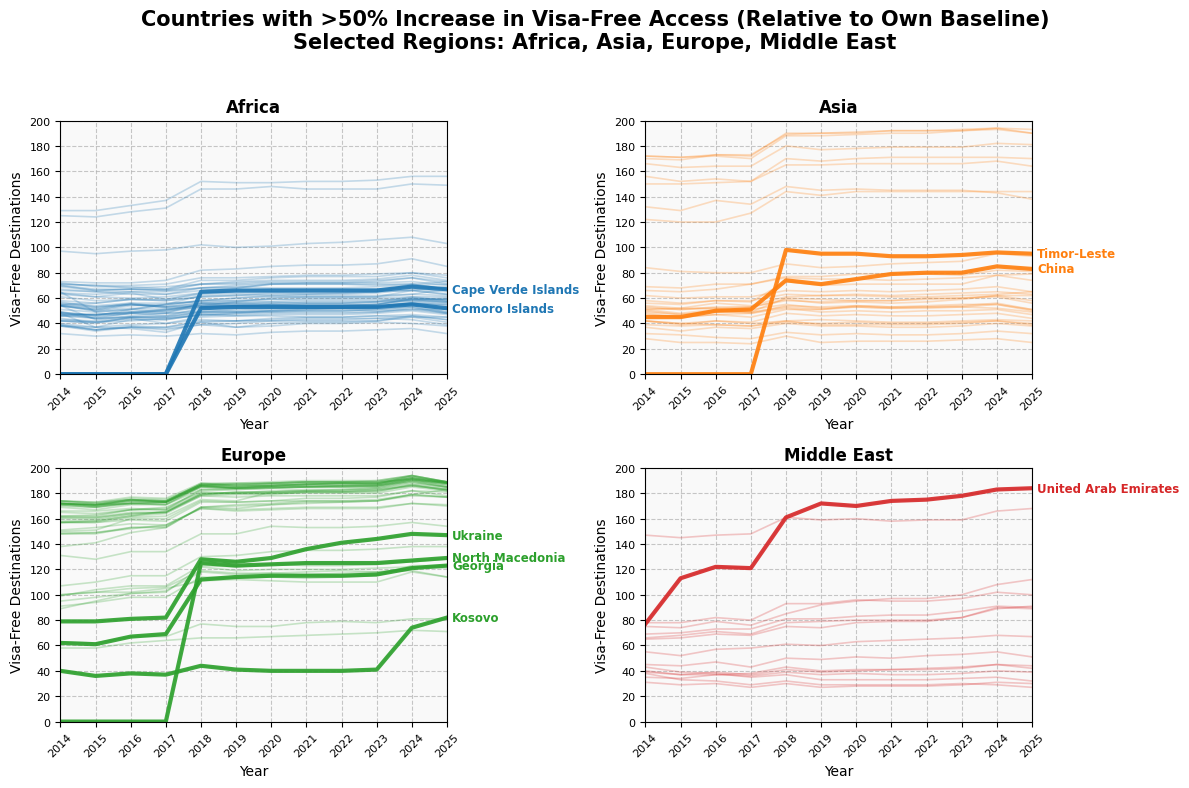

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Sort and prepare data
df_plot2 = df.sort_values(["region", "country", "year"])

regions = ["Africa", "Asia", "Europe", "Middle East"]

palette = sns.color_palette("tab10", n_colors=len(regions))
region_to_color = {r: c for r, c in zip(regions, palette)}

growth_df = (
    df_plot2.groupby("country")
    .agg(first_year=('year', 'min'),
         last_year=('year', 'max'),
         first_val=('visa_free_count', 'first'),
         last_val=('visa_free_count', 'last'))
    .reset_index()
)
growth_df["growth_pct"] = ((growth_df["last_val"] - growth_df["first_val"]) / growth_df["first_val"]) * 100

highlight_countries = growth_df.loc[growth_df["growth_pct"] > 50, "country"].tolist()

y_min = np.floor(df_plot2["visa_free_count"].min() / 20) * 20
y_max = np.ceil(df_plot2["visa_free_count"].max() / 20) * 20
y_ticks = np.arange(y_min, y_max + 1, 20)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for ax, reg in zip(axes, regions):
    data_reg = df_plot2[df_plot2["region"].str.lower() == reg.lower()].copy()

    if data_reg.empty:
        ax.text(0.5, 0.5, f"No data for {reg}", ha='center', va='center', fontsize=10)
        ax.set_title(reg)
        continue

    base_color = region_to_color[reg]

    for country, grp in data_reg.groupby("country"):
        ax.plot(
            grp["year"],
            grp["visa_free_count"],
            color=(*base_color, 0.25),   
            linewidth=1.2
        )

    for country, grp in data_reg.groupby("country"):
        if country in highlight_countries:
            ax.plot(
                grp["year"],
                grp["visa_free_count"],
                color=base_color,
                linewidth=3,
                alpha=0.9                    
            )
            last_row = grp.iloc[-1]
            ax.text(
                last_row["year"] + 0.15,
                last_row["visa_free_count"],
                country,
                color=base_color,
                fontsize=8.5,
                weight='bold',
                va="center"
            )

    ax.set_yticks(y_ticks)
    ax.set_ylim(y_min, y_max)
    ax.tick_params(axis='y', labelsize=8)

    ax.set_title(f"{reg}", fontsize=12, weight='bold')
    ax.set_xlabel("Year", fontsize=10)
    ax.set_ylabel("Visa-Free Destinations", fontsize=10)
    ax.grid(True, linestyle="--", linewidth=0.8, alpha=0.7)
    ax.set_facecolor("#f9f9f9")
    ax.set_xticks(range(2014, 2026))
    ax.set_xlim(2014, 2025)
    ax.tick_params(axis='x', rotation=45, labelsize=8)

fig.suptitle("Countries with >50% Increase in Visa-Free Access (Relative to Own Baseline)\nSelected Regions: Africa, Asia, Europe, Middle East",
             fontsize=15, weight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

#### Plot 3: Non-Free Access Types by Passport Strength Quartile

For the third plot, we go beyond visa-free counts to examine passport power. Passport power does not end at how many places someone can enter visa-free as the type of process travellers face also matters. A stacked bar chart is suitable here because it allows us to compare, across four passport-strength quartiles, how much each group relies on traditional visas, e-Visas, visas-on-arrival and eTAs. This makes it easy to see whether stronger passports enjoy more streamlined access routes while weaker passports face heavier administrative barriers.

To prepare the data for this visualisation, countries are first grouped into quartiles according to their visa-free destinations in 2025. We then use country_lists.csv to calculate, for each passport, the share of destinations that fall into each non-free access category. Visa-free destinations are excluded from this calculation so that the proportions sum to one over non-free access only. Countries with incomplete or inconsistent access-type records are removed. Finally, we average these proportions within each quartile to obtain a single set of four percentages for each passport group, and plot them as stacked bars, with each colour segment representing one access type.

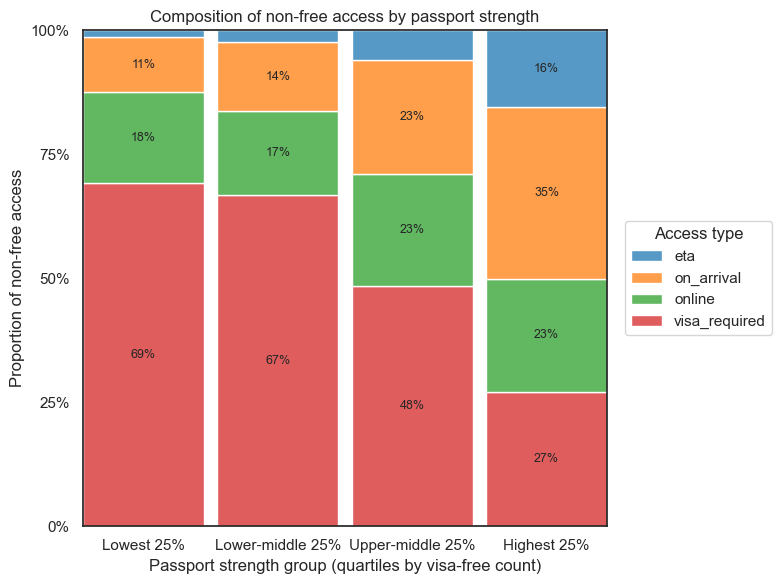

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

p_free   = pd.read_csv("../src/visa_free_access_clean.csv")
p_oa     = pd.read_csv("../src/visa_on_arrival.csv")
p_online = pd.read_csv("../src/visa_online_clean.csv")
p_eta    = pd.read_csv("../src/visa_electronic_travel_authorisation.csv")
p_req    = pd.read_csv("../src/visa_required_clean.csv")

def count_by_passport(df):
    return df.groupby("country_name")["name"].nunique()

free_ct   = count_by_passport(p_free).rename("free")
oa_ct     = count_by_passport(p_oa).rename("on_arrival")
online_ct = count_by_passport(p_online).rename("online")
eta_ct    = count_by_passport(p_eta).rename("eta")
req_ct    = count_by_passport(p_req).rename("visa_required")

df = pd.concat([free_ct, oa_ct, online_ct, eta_ct, req_ct], axis=1).fillna(0).astype(int)

quartile_labels = ["Lowest 25%", "Lower-middle 25%", "Upper-middle 25%", "Highest 25%"]
df["free_group_q"] = pd.qcut(df["free"], 4, labels=quartile_labels)

parts = ["visa_required","online","eta","on_arrival"]
agg = df.groupby("free_group_q")[parts].sum().reindex(quartile_labels)
long_df = agg.reset_index().melt(id_vars="free_group_q", var_name="Visa_Type", value_name="Count")

sns.set_theme(style="white")

stack_order = ["eta", "on_arrival", "online", "visa_required"]

fig, ax = plt.subplots(figsize=(8,6))
sns.histplot(
    data=long_df,
    x="free_group_q",
    weights="Count",
    hue="Visa_Type",
    hue_order=stack_order,
    multiple="fill",
    palette="tab10",
    shrink=0.9,
    ax=ax
)

ax.set_xticklabels(quartile_labels)
ax.set_ylabel("Proportion of non-free access")
ax.set_xlabel("Passport strength group (quartiles by visa-free count)")
ax.set_title("Composition of non-free access by passport strength")

ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
ax.set_yticklabels(["0%", "25%", "50%", "75%", "100%"])
ax.set_ylim(0, 1)

sns.move_legend(ax, "center left", bbox_to_anchor=(1.02, 0.5), title="Access type")

for p in ax.patches:
    h = p.get_height()
    if h >= 0.10:
        x_c = p.get_x() + p.get_width()/2
        y_c = p.get_y() + h/2
        ax.text(x_c, y_c, f"{h*100:.0f}%", ha="center", va="center", fontsize=9)

plt.tight_layout()
plt.show()

### 4. Discussion

#### Plot 1: World Map

The variation of citizenships across the globe is starkly divided in the previous map. The most powerful passports are seen in Europe, North America and in the advanced economies of Asia in Singapore, Japan and South Korea gaining widespread access to 180-195 places through visa-free or visa-on-arrival access. By turn, passports in the middle range found in Latin America, the Middle East and parts of Eastern Europe can access 100-140 places, enjoying moderate mobility but significantly behind the best passports. The weakest passports are found in Sub-Saharan Africa, South Asia and the unstable countries of the Middle East. Many of these passports admit access to fewer than 60-80 places, whilst the extreme cases such as Afghanistan have fewer than 30 visa-free places. The pattern displayed in the map reveals much about the global inequalities existing in the world today. Social-economic development certified by political stability is seen as the mark of lower-risk countries and those receiving the benefits of large-scale visa-waiver agreements, whilst those transformations characterised by instability, sanctions or higher crime-migration risk are seen as necessitating greater visa controls and reduced mobility. The map ultimately depicts clearly how global variations in economic development, political stability and levels of diplomatic trust lead to significant differences in issues pertaining to passport power.


#### Plot 2: Line Graph

For all 4 regions, the visa-free count of most of the countries with relatively low passport strength remain low across time, while the visa-free count of countries with relative stronger passport strength see a steady increase across time. For instance, the passport strength of Europe stays high with steady small gains over the years. The gradual increases reflect economic development in these highly developed countries (Zarpli, 2025). In contrast, the visa-free count of most of the African countries remains relatively low and stable over the years. Between 2017 and 2018, almost all of the countries saw a rise in visa-free counts. Since countries have different definitions for visa and some describe their ETA program as a type of visa, it is likely that Henley & Partners standadized and started to classify terms such as ETA and visa-on-arrival as equivalent to visa-free from 2018 onward. Moreover, several countries saw a sharp increase in visa-free counts(over 50%). These countries may be part of high-mobility regional blocs (i.e. Schengen Zone, Gulf Co-operation Council) which already had broad travel programs and ETAs. In addition to the rise in passport strength between 2017 and 2018, countries such as UAE, Ukraine and Kososvo saw rapid increase in other years as well. The UAE’s rapid rise is largely attributed to expansion in diplomatic & economic ties (Ata, 2025). The European Union granted visa free travel to Ukraine and Kosovox because governments use visa policies as diplomatic tools to strengthen alliances and regional integration (Zarpli, 2025). 

#### Plot 3: Stacked Bar Chart
The access-type distribution reveals deeper layers of global travel inequality that cannot be captured by visa-free counts alone. Holders of weaker passports face the highest levels of administrative friction, with traditional visas dominating their mobility landscape. These visas typically involve more extensive documentation, higher financial costs and longer waiting periods, alongside a greater risk of rejection. As passports become stronger, the administrative burden also gradually eases. Travellers gain access to visas-on-arrival and e-Visas, and the strongest passports can rely substantially on eTAs—systems that, as noted by Henley & Partners (2025a), require minimal effort and offer very high approval rates. Even when full visa-free access is not available, the processes available to stronger passports are generally faster, simpler and more reliable. This suggests that qualitative aspects of travel, or how smooth journey is, vary widely across passport groups. Strong passports benefit from streamlined digital systems and discretionary trust, while weaker passports encounter more restrictive and time-consuming procedures. These findings reinforce that global mobility is shaped not only by where one can travel, but also by how easily one can get there.

### 5. Conclusion

Overall, our analysis shows that passport power varies sharply across world regions because it reflects deeper global inequalities in economic development, political stability and international relations. The world map demonstrates a clear divide: Europe, North America and advanced Asian economies consistently hold the strongest passports, while Sub-Saharan Africa, South Asia and conflict-affected Middle Eastern states remain among the weakest. The time-series visualisation shows that although visa-free access has generally increased over the past decade, the mobility gap between regions remains wide, with only a few countries—such as Singapore, Ukraine and the UAE—experiencing rapid improvements linked to stronger diplomatic ties or changes in regional integration. The access-type comparison further reveals that passport inequality is not only about the number of destinations a traveller can enter, but also about how easily they can enter them: stronger passports have access to faster and more predictable pathways (e.g., eTAs and visa-on-arrival), while weaker passports still rely heavily on traditional visas that impose high administrative burdens. Taken together, these findings highlight that global mobility is shaped by both the quantity and the quality of access, and that long-standing structural factors—economic strength, political stability and diplomatic trust—continue to determine how freely different populations can move around the world.

### 6. References
---
Ata, H. (2025, July 22). UAE passport ranks 8th globally and strongest in Arab world in 2025 Henley Index. Gulf News. https://gulfnews.com/uae/government/uae-passport-ranks-8th-globally-and-strongest-in-arab-world-in-2025-henley-index-1.500207495

Hung, J. (2025). China’s passport power and Belt-and-Road Initiative: An investigation of passport relations. Politics. https://doi.org/10.1177/02633957251337866

Henley & Partners. (2022). Determinants of Passport Strength. https://www.henleyglobal.com/publications/global-mobility-report/2022-q1/travel-mobility-trends/wealth-geopolitics-and-great-mobility-divide

Henley & Partners. (2025a). Electronic Travel Authorisation Overview.

Henley & Partners. (2025b). Global Mobility Report: Visa Systems and Administrative Barriers.

Henley Passport Index Data. (2025). Retrieved from https://github.com/rfordatascience/tidytuesday/tree/main/data/2025/2025-09-09

### 7. About
This project was developed for DSA2101 Essential Data Analytics Tools: Data Visualisation at the National University of Singapore (NUS). The team is comprised of the following members:




| **Name**            | **Year** | **Major**                  | **Responsibilities**                                  |
| ------------------- | -------- | -------------------------- | ----------------------------------------------------- |
| **Wang Yufei**      | 2        | Data Science and Analytics | Plot 1 code, Plot 1 discussion and interpretation     |
| **Zhou Lingxuan**   | 2        | Data Science and Analytics | Plot 2 code, Plot 2 discussion and interpretation     |
| **Liu Xiangyu**     | 2        | Data Science and Analytics | Plot 3 code, Plot 3 discussion and interpretation     |
| **Wu Zetong**       | 2        | Data Science and Analytics | Full data cleaning, data cleaning section write-up    |
| **Anna Ni Houjing** | 2        | Data Science and Analytics | Introduction, conclusion, and report cohesion editing |
